#### About   
This Python notebook aims to generate a binary classification model. We will implement PCA and perform feature selection using Pearson correlation as the filter. Then, we will use K-means clustering to create predictions on the test dataset and evaluate the results using precision score, recall score, F1 score, accuracy score, confusion matrix, and AUC-ROC curve. Additionally, we will perform linkage hierarchical clustering and use a dendrogram to determine the number of clusters suggested by the clustering method. Lastly, we will evaluate the quality of clusters using the silhouette score.

#### Importing Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore') # Keeping the notebook clean

#### Task 1: Data pre-processing and diagnosis

In [52]:
# Load the data
X = pd.read_excel('rescaled_gene_expression_T.xlsx') # Already transposed and removed Gene Description via excel
y = pd.read_csv('Ground_truth_patient_tumor_type.csv')

# Renaming the 'sample' column to 'Gene Accession Number' in y for later merging
y.rename(columns={'sample':'Gene Accession Number'}, inplace=True) 

In [53]:
# Convert 'Gene Accession Number' column to string
X['Gene Accession Number'] = X['Gene Accession Number'].astype(str)

# Remove all the rows which have 'call' in the 'Gene Accession Number' column (ie only keeping gene expression values)
X = X[~X['Gene Accession Number'].str.contains('call')]

# Reset the index
X = X.reset_index(drop=True)

# Converting complete dataframe to float
X = X.astype(float)

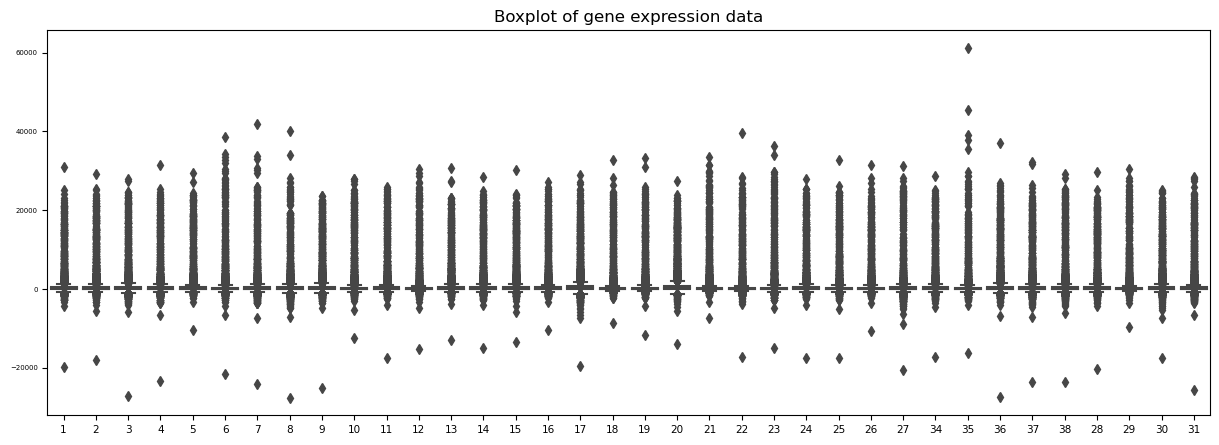

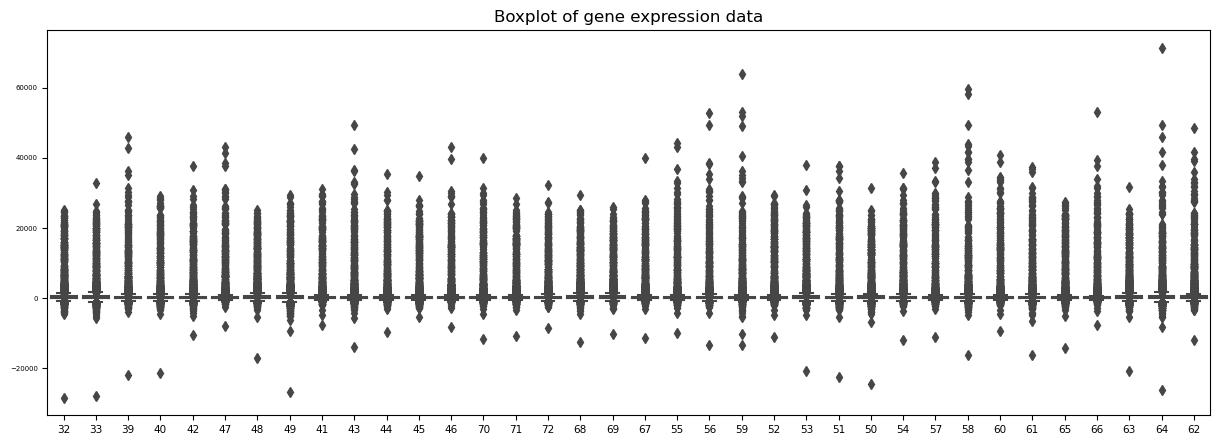

In [54]:
Transposed_X = X.T # Transposing the dataframe

# Check the distribution of the data by plotting a boxplot for the groups of 12 genes
for i in range(0, 72, 36):
    plt.figure(figsize=(15, 5))
    boxplot_data = Transposed_X.iloc[:, i:i+36]
    boxplot_data.columns = Transposed_X.iloc[0, i:i+36].values.tolist()
    boxplot_data.columns = boxplot_data.columns.astype(int)
    boxplot_data = boxplot_data[1:]
    sns.boxplot(data=boxplot_data)
    plt.title('Boxplot of gene expression data')
    plt.show()

Based on the plots, normalisation does not seem necessary as the medians are largely similar. 

In [56]:
X_Labeled = X.copy()

# Concatenating the X and y dataframes based on 'Gene Accession Number' column
X_Labeled = pd.concat([X_Labeled, y], axis=1, join='inner')

# Converting the 'cancer' column to 0 and 1 based on 'ALL' and 'AML'
X_Labeled['cancer'] = X_Labeled['cancer'].map({'ALL':0, 'AML':1})

In [57]:
X_Labeled.head()

,Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,Gene Accession Number,cancer
0,1.0,-214.0,-153.0,-58.0,88.0,-295.0,-558.0,199.0,-176.0,252.0,...,-125.0,389.0,-37.0,793.0,329.0,36.0,191.0,-37.0,1,0
1,2.0,-139.0,-73.0,-1.0,283.0,-264.0,-400.0,-330.0,-168.0,101.0,...,-36.0,442.0,-17.0,782.0,295.0,11.0,76.0,-14.0,2,0
2,3.0,-76.0,-49.0,-307.0,309.0,-376.0,-650.0,33.0,-367.0,206.0,...,33.0,168.0,52.0,1138.0,777.0,41.0,228.0,-41.0,3,0
3,4.0,-135.0,-114.0,265.0,12.0,-419.0,-585.0,158.0,-253.0,49.0,...,218.0,174.0,-110.0,627.0,170.0,-50.0,126.0,-91.0,4,0
4,5.0,-106.0,-125.0,-76.0,168.0,-230.0,-284.0,4.0,-122.0,70.0,...,57.0,504.0,-26.0,250.0,314.0,14.0,56.0,-25.0,5,0


#### Task 2: PCA implementation

Applying Apply Principal Component Analysis (PCA) on the gene expression data and visualising the result of the PCA analysis.


In [58]:
# Applying PCA to the data
n_components = 20
pca = PCA(n_components=n_components)
pca_out = pca.fit_transform(X)

In [59]:
# Showing the percentage of variance explained by each PC
for i in range(n_components):
    print("Variance explained by PC", i+1, ": ", pca.explained_variance_ratio_[i])
print("Sum of variance explained by all PCs: ", sum(pca.explained_variance_ratio_))

Variance explained by PC 1 :  0.1742776834828553
Variance explained by PC 2 :  0.10338643107402454
Variance explained by PC 3 :  0.07690230109641341
Variance explained by PC 4 :  0.058532384482006684
Variance explained by PC 5 :  0.05777572799992747
Variance explained by PC 6 :  0.050206771810076795
Variance explained by PC 7 :  0.04558312788092627
Variance explained by PC 8 :  0.03236626930487362
Variance explained by PC 9 :  0.028475797525932354
Variance explained by PC 10 :  0.024103600814212388
Variance explained by PC 11 :  0.022387783625423596
Variance explained by PC 12 :  0.01865432635243625
Variance explained by PC 13 :  0.018166645657768644
Variance explained by PC 14 :  0.01731118229099495
Variance explained by PC 15 :  0.013618261131950197
Variance explained by PC 16 :  0.01305303512396301
Variance explained by PC 17 :  0.012698510306781386
Variance explained by PC 18 :  0.01163618493864835
Variance explained by PC 19 :  0.0112506254693067
Variance explained by PC 20 :  0.0

The first principal component (PC1) explains 17.43% of the variance within the dataset, which is the highest individual contribution among all components. The second principal component (PC2) accounts for 10.34% of the variance. The contribution of each subsequent principal component decreases, with PC3 through PC20 explaining between 7.69% and 0.95% of the variance, respectively. Collectively, the 20 principal components account for roughly 80% of the total variance in the dataset.

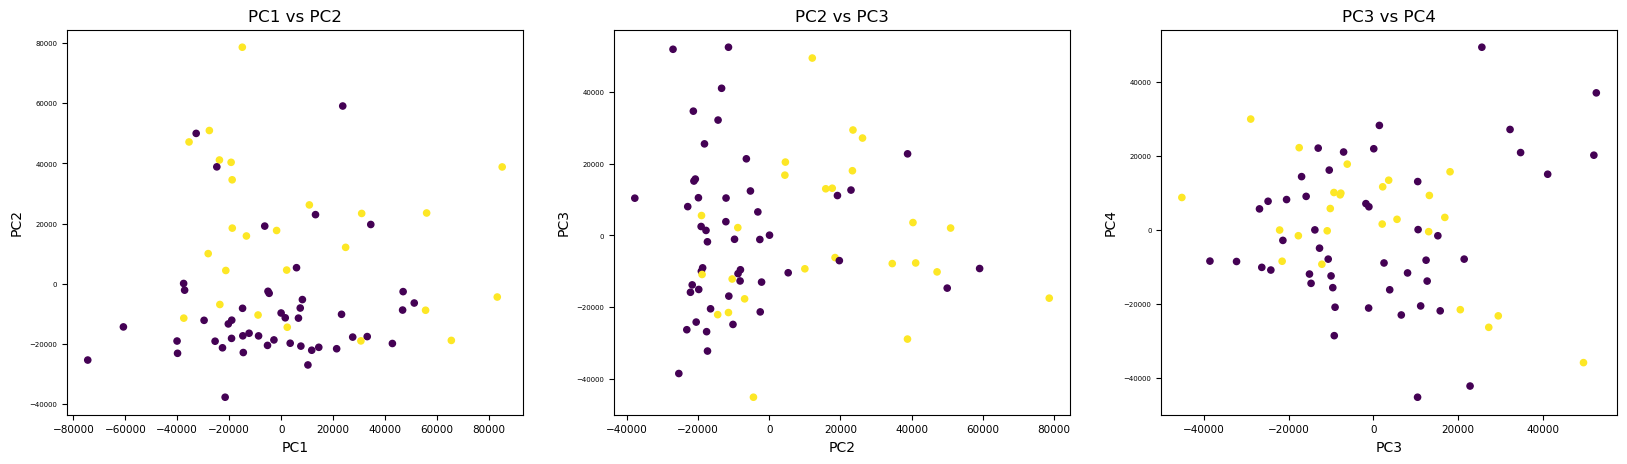

In [60]:
# Show figures of PC1 vs PC2, PC2 vs PC3, and PC3 vs PC4
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(pca_out[:, 0], pca_out[:, 1], c=X_Labeled['cancer'], cmap='viridis', s=20)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('PC1 vs PC2')
ax[1].scatter(pca_out[:, 1], pca_out[:, 2], c=X_Labeled['cancer'], cmap='viridis', s=20)
ax[1].set_xlabel('PC2')
ax[1].set_ylabel('PC3')
ax[1].set_title('PC2 vs PC3')
ax[2].scatter(pca_out[:, 2], pca_out[:, 3], c=X_Labeled['cancer'], cmap='viridis', s=20)
ax[2].set_xlabel('PC3')
ax[2].set_ylabel('PC4')
ax[2].set_title('PC3 vs PC4')
plt.show()

**Findings:** 

PC1 vs PC2:
The scatter plot of PC1 against PC2 shows a distribution where there is some degree of separation between cancerous and non-cancerous samples, indicated by two distinct color clusters. This suggests that these two components capture variance that is relevant to the distinction between cancerous and non-cancerous gene expression profiles. 

PC2 vs PC3:
The plot of PC2 against PC3 also demonstrates a pattern where the two groups of samples are distinguishable to an extent. However, the degree of overlap is noticeable, indicating that while these components contribute to separating the samples, they are less discriminative than PC1.  

PC3 vs PC4:
The plot for PC3 against PC4 shows the samples are more intermixed compared to the previous plots. This suggests that these principal components are less effective in distinguishing between the cancerous and non-cancerous samples when considered alone.  

<Figure size 600x1500 with 0 Axes>

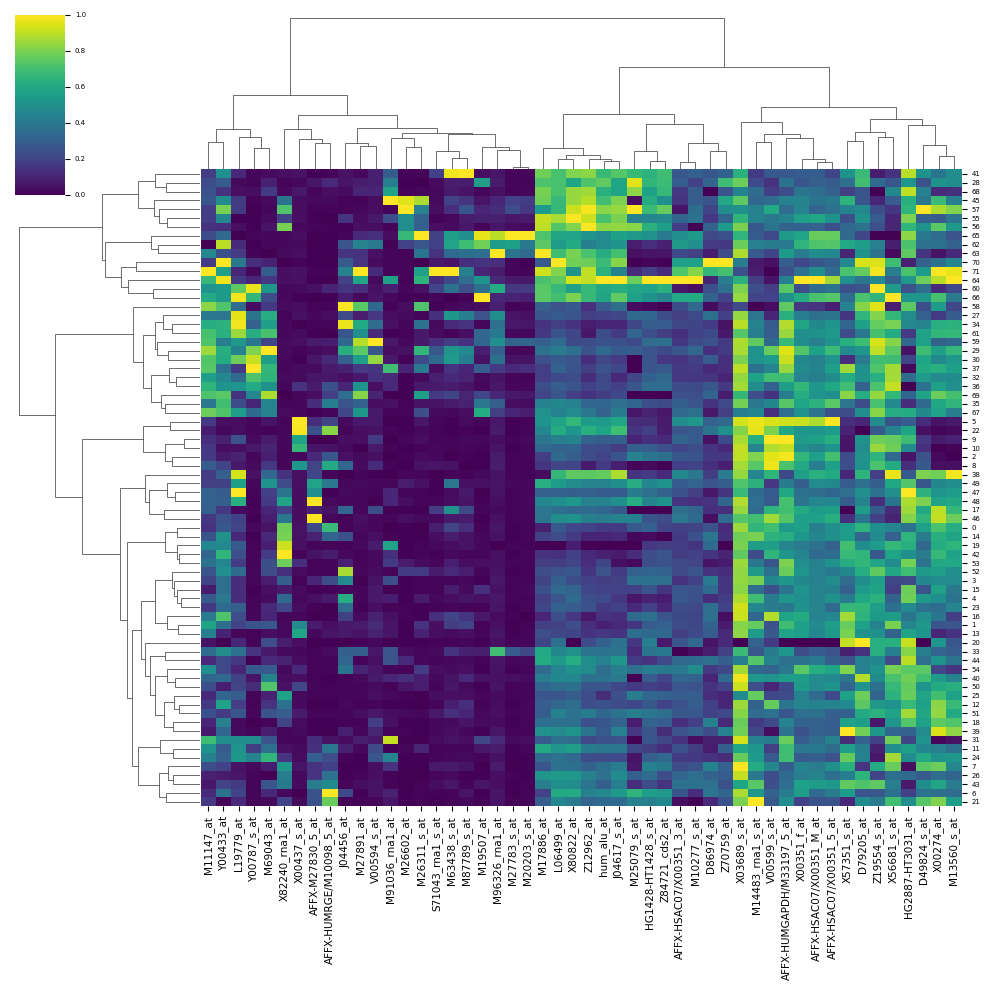

In [61]:
variances = X.var() # Calculate the variance of each gene

# Identify the top 50 genes with the highest variance
top_50_genes = variances.nlargest(50).index

# Extract the expression data for these top 50 genes
top_50_genes_data = X[top_50_genes]

# Set smaller font size for the labels globally
plt.rcParams['xtick.labelsize'] = 7.5
plt.rcParams['ytick.labelsize'] = 5

# Plotting the heatmap
plt.figure(figsize=(6, 15))
sns.clustermap(top_50_genes_data, method='ward', metric='euclidean', cmap='viridis', standard_scale=1)
plt.show()

plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'

The variability of each gene was calculated using variance as the measure of spread. The 50 genes exhibiting the highest variance were then selected for further analysis.  

The heatmap visualization aimed to identify patterns in gene expression variability across samples, focusing on the 50 genes with the highest variance. The color-coding represents standardized expression levels, with hierarchical clustering grouping together genes and samples with similar profiles.  

The vertical dendrogram shows several distinct clusters, indicating groups of genes with similar expression patterns across the samples. Some clusters appear tightly linked, suggesting very similar expression profiles, while others are more loosely connected (diverse).  

The horizontal dendrogram represents the hierarchical clustering of samples indicating samples have similar overall expression profiles for the top 50 variable genes.

#### Task 3: Feature selection

Dividing the data into training, and testing set. Doing feature selection on the training set, using a filter-based Pearson correlation method.

In [62]:
# Dropping the Gene Accession Number column as it is just an identifier
X = X.drop('Gene Accession Number', axis=1)

In [63]:
# Splitting the data into training and testing sets, 20% of the data will be used for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, X_Labeled['cancer'], test_size=0.2, random_state=42)

In [64]:
# Calculate the absolute value of Pearson correlation
correlation_matrix = X_train.corrwith(y_train)
correlation_matrix = correlation_matrix.abs()

# Sort features by their correlation in descending order and select the top 50
top_50_features = correlation_matrix.sort_values(ascending=False).head(50).index.tolist()

# Filter the training and testing sets to keep only the selected features
X_train_selected = X_train[top_50_features]
X_test_selected = pd.DataFrame(X_test, columns=X_train.columns)[top_50_features]

Calculating the absolute value of the Pearson correlation between the features and the target variable. The top 50 features with the highest correlation are selected and used to filter the training and testing datasets. This helps in reducing the dimensionality of the data and focusing on the most relevant features for the target variable.

#### Task 4: Clustering

Applying K-mean clustering to the data

In [65]:
# Applying KMeans to the data
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train)

# Generating predicted label for test data, y_pred.
y_pred = kmeans.predict(X_test)

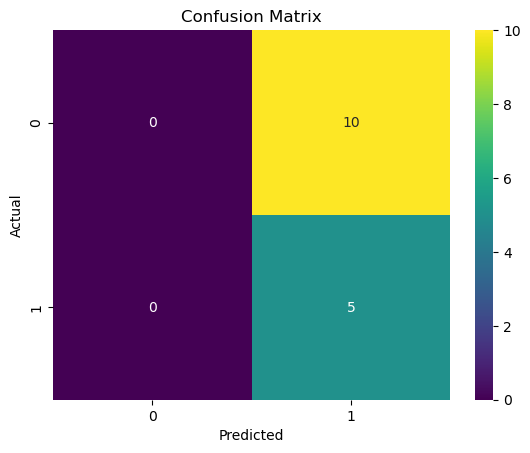

In [66]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [67]:
# Calculating the precision, recall, f1-score, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.3333333333333333
Recall:  1.0
F1 Score:  0.5
Accuracy:  0.3333333333333333


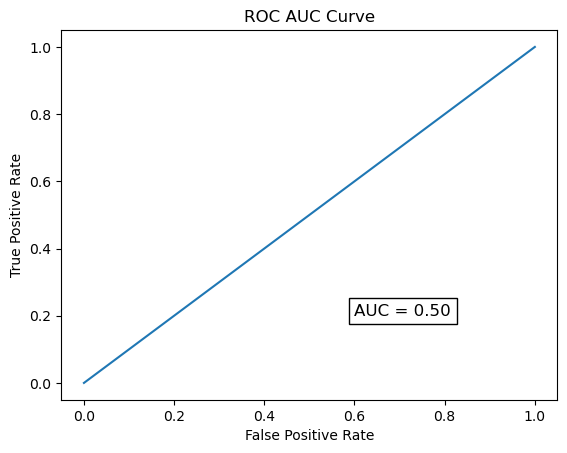

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')

auc_score = roc_auc_score(y_test, y_pred)
auc_label = f'AUC = {auc_score:.2f}'
plt.text(0.6, 0.2, auc_label, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

**Model Evaluation:**  
- Precision: Approximately 0.33, indicating that when the model predicts the positive class, it is correct about 33% of the time.  
- Recall: 1.0, suggesting that the model identified all true positive cases in the test set; however, this also implies a high number of false positives since the precision is low.  
- F1 Score: 0.5, which is a weighted average of precision and recall. This score is not high, reflecting the imbalance between precision and recall.  
- Accuracy: Approximately 0.33, indicating that the model correctly predicts the class labels for 33% of the test set.  

A high recall with low precision suggests that while the model is capturing the positive class, it is also misclassifying many negative instances as positive. The model's ability to distinguish between the classes is no better than random chance, as indicated by an AUC of 0.50.

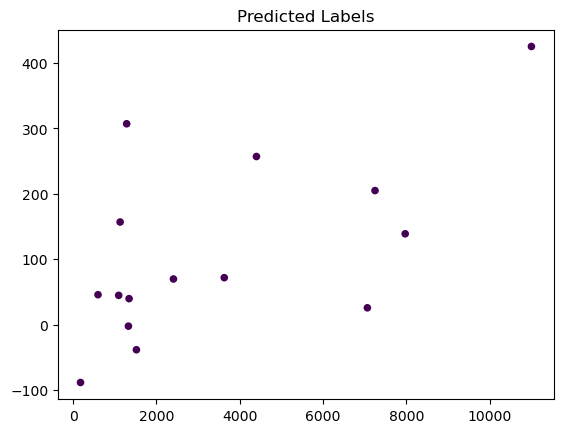

In [69]:
# Visualise the predictive labels
plt.scatter(X_test_selected.iloc[:, 0], X_test_selected.iloc[:, 1], c=y_pred, cmap='viridis', s=20)
plt.title('Predicted Labels')
plt.show()

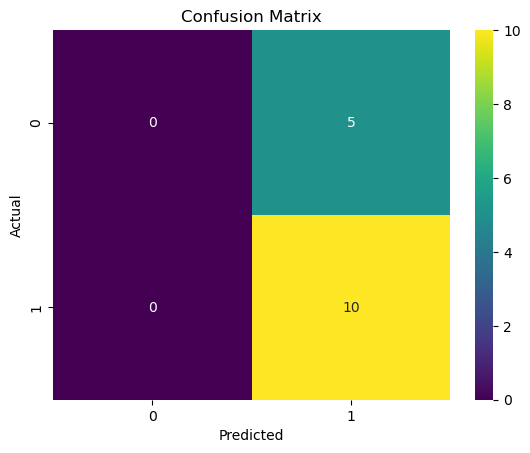

In [70]:
# Switching y_test 0 to 1 and 1 to 0
y_test_inverted = y_test.replace({0:1, 1:0})

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test_inverted, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Calculating the precision, recall, f1-score, and accuracy with the inverted labels
precision = precision_score(y_test_inverted, y_pred)
recall = recall_score(y_test_inverted, y_pred)  
f1 = f1_score(y_test_inverted, y_pred)
accuracy = accuracy_score(y_test_inverted, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)   

Precision:  0.6666666666666666
Recall:  1.0
F1 Score:  0.8
Accuracy:  0.6666666666666666


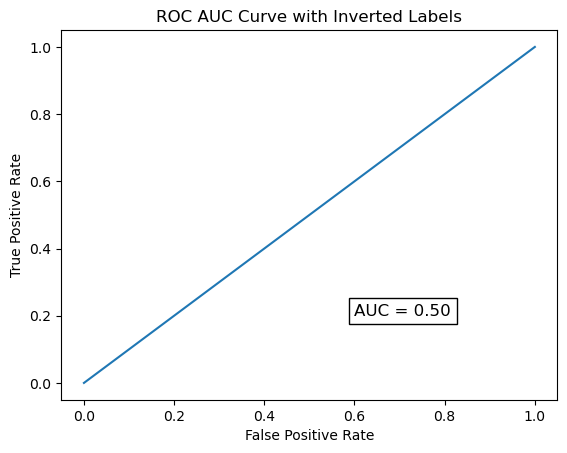

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve with Inverted Labels')

auc_score = roc_auc_score(y_test_inverted, y_pred)
auc_label = f'AUC = {auc_score:.2f}'
plt.text(0.6, 0.2, auc_label, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

The labels in y_test were switched such that the previous '0' class is now '1', and '1' is now '0'.  

**Model Evaluation:**  
- Precision: Approximately 0.67, which means that after inverting the labels, when the model predicts the positive class, it is correct about 67% of the time.  
- Recall: Remains at 1.0, indicating that the model identifies all instances of the new positive class in the test set. This still suggests that there could be a significant number of false positives.  
- F1 Score: Has improved to 0.8, reflecting a better balance between precision and recall than before the inversion.  
- Accuracy: Has increased to approximately 0.67, meaning the model now correctly predicts the class labels for 67% of the test set.  

Despite the improved precision, accuracy, and F1 score, the ROC AUC Curve suggests that the model's ability to discriminate between classes has not improved.

The AUC score for an ROC curve is indeed invariant to the way we encode the labels. The AUC of 0.50 suggests that the model has no discriminative ability to distinguish between the positive and negative classes regardless of how the labels are encoded (It is random). When we invert the labels the AUC remains the same.

#### Task 5: Hierarchical clustering

Utilising hierarchical clustering methods, like linkage clustering, to analyse the full data X and evaluate the clustered result.

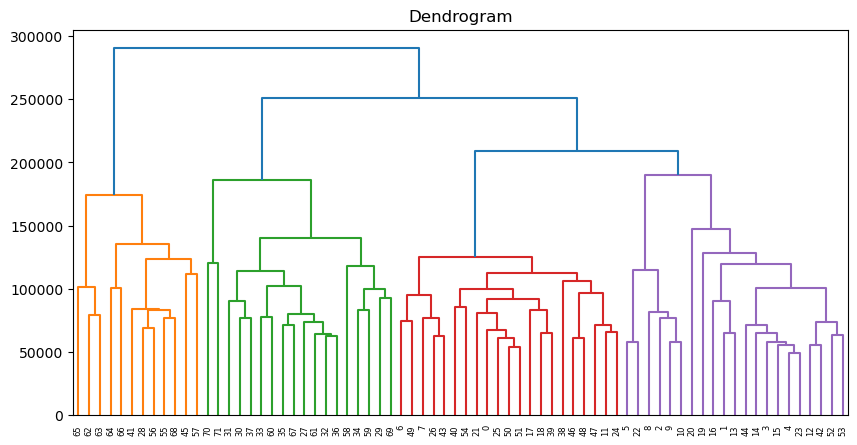

In [73]:
# Applying hierarchical clustering (Linkage Clustering) to the data
linkage_matrix = linkage(X, method='ward', metric='euclidean')

# Plotting the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=X.index, leaf_rotation=90)
plt.title('Dendrogram')
plt.show()

The dendrogram suggests 3 clusters for the Linkage Clustering method (arguably there can be 4 but the orange and green are very similar, also we may group the green and orange and purple and red suggesting 2 clusters)

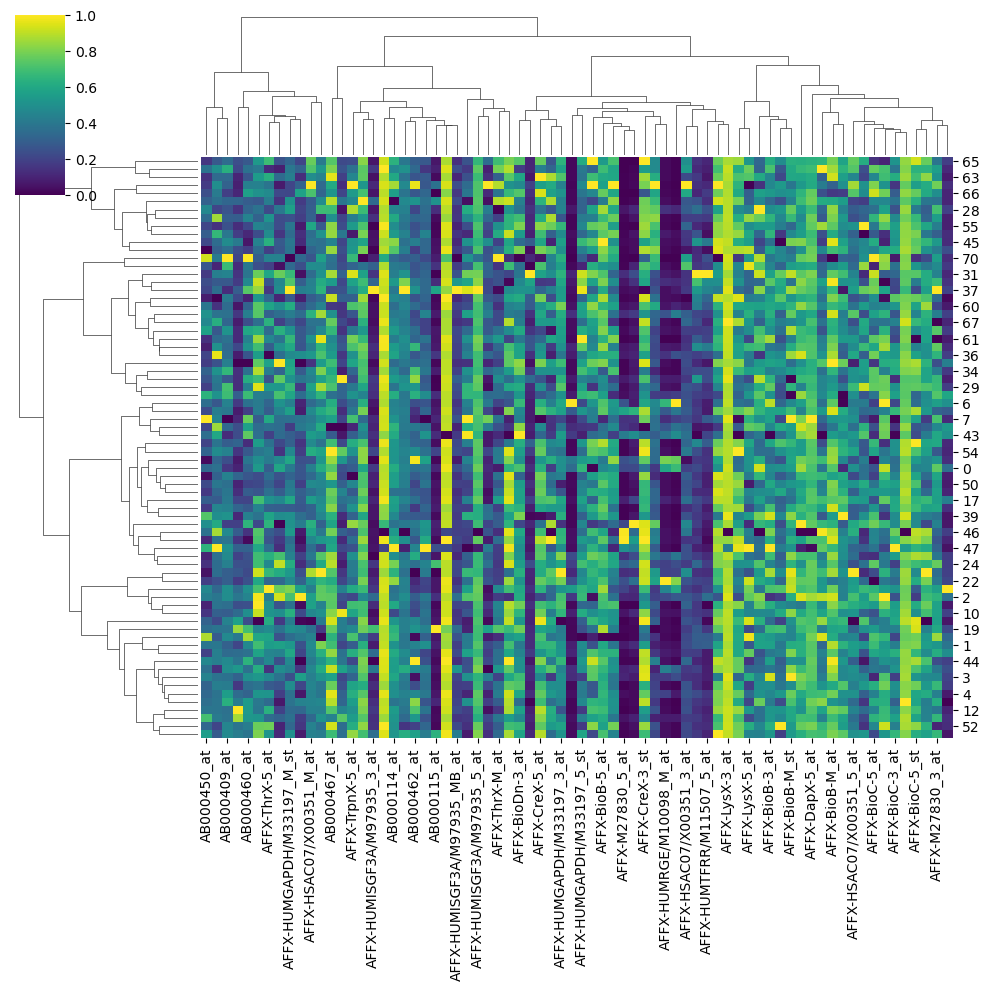

In [77]:
# Creating the heatmap using the same linkage matrix
sns.clustermap(X, cmap='viridis', standard_scale=1, 
               row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               figsize=(10, 10))

plt.show()

In [75]:
# Cutting the dendrogram at a determined number of clusters

clusters = fcluster(linkage_matrix, 2, criterion='maxclust')
silhouette_avg = silhouette_score(X, clusters, metric='euclidean') # Computing the Silhouette Score
print('The average silhouette_score (2) is:', silhouette_avg)

clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
silhouette_avg = silhouette_score(X, clusters, metric='euclidean') # Computing the Silhouette Score
print('The average silhouette_score (3) is:', silhouette_avg)

clusters = fcluster(linkage_matrix, 4, criterion='maxclust')
silhouette_avg = silhouette_score(X, clusters, metric='euclidean') # Computing the Silhouette Score
print('The average silhouette_score (4) is:', silhouette_avg)

The average silhouette_score (2) is: 0.15650007497879465
The average silhouette_score (3) is: 0.10525392347889
The average silhouette_score (4) is: 0.0667449402840133


The analysis utilized the Silhouette Score as a metric to evaluate the quality of hierarchical clustering, focusing on the balance between within-cluster cohesion and between-cluster separation. This score, ranging from -1 to 1, serves as a gauge for the appropriateness of the clustering, where a score closer to 1 indicates a strong distinction between clusters and a high degree of intra-cluster similarity.  

Upon examining the clustering outcomes for different numbers of clusters (2, 3, and 4), the results reveal a decreasing trend in the Silhouette Scores as the number of clusters increases. 
- With 2 clusters, the Silhouette Score was the highest at 0.1565, suggesting a moderate level of cluster definition but indicating potential for overlap or insufficient separation between the clusters.  
- Increasing the cluster count to 3 resulted in a reduced score of 0.1053, implying a decline in clustering quality with less distinction between clusters and potentially more intra-cluster variance.  
- Further expanding to 4 clusters led to the lowest score of 0.0667, indicating the poorest clustering performance among the tested configurations, with significant overlap or ambiguity in cluster membership.  

These findings suggest that the dataset's structure might not naturally partition into a higher number of distinct clusters, as indicated by the diminishing quality of clustering with an increased number of clusters. The best performance was observed with the simplest model of 2 clusters, although the overall low Silhouette Scores across all configurations highlight challenges in achieving clear and cohesive clustering with the data at hand. This analysis underscores the importance of the Silhouette Score in guiding the selection of an optimal cluster count, emphasizing that, in this case, fewer clusters correspond to marginally better, yet still limited, clustering effectiveness.  

#### Reflection & Summary

- Need to learn more Clustering methods and evaluation techniques  
- Need to learn more about checking distribution of data (when we have alot of features)  
- Learnt how silhouette score assess the quality of clusters formed during clustering analysis. It takes into account both the cohesion (Within-cluster dispersion) of data points within a cluster and the separation (Between-cluster dispersion) between different clusters.